In [7]:
import torch
import torch.nn as nn
import einops

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        # Attention weights of the different heads are stored in the same tensors.

        # We put all the attention heads in the same Linears Layers:
        self.values = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.keys = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias=False)

        # fc_out after having concatenated the results of the attention of each head
        self.fc_out = nn.Linear(self.embed_size, embed_size)

    def init2(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = self.embed_size//self.heads
        assert (self.head_dim * self.heads == self.embed_size )
        
        self.values = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.keys = nn.Linear(self.embed_size, self.embed_size, bias = False)

        self.fc_out = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, values, keys, queries, mask):
        """
        values: (N, value_len, embed_size)
        keys: (N, keys_len, embed_size)
        queries: (N, queries_len, embed_size)

        mask: None or (N, heads, query_len, key_len) 
        if mask == 0, attention matrix  -> float("-1e20") (big negative value)
        Ignore the mask, it's too difficult at the beginning.
        """
        # Get number of training examples
        N = queries.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Compute the values keys and queries
        values = self.values(values)  # (N, value_len, embed_size)
        keys = self.keys(keys)  # (N, key_len, embed_size)
        queries = self.queries(queries)  # (N, query_len, embed_size)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Compute the similarity between query*keys
        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for better stability
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)


        # We compute the attention (aka the ponderated value)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.


        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return self.fc_out(out)
    
    def forward2(self, values, keys, queries, mask):
        """
        values: (N, value_len, embed_size)
        keys: (N, keys_len, embed_size)
        queries: (N, queries_len, embed_size)

        mask: None or (N, heads, query_len, key_len) 
        if mask == 0, attention matrix  -> float("-1e20") (big negative value)
        Ignore the mask, it's too difficult at the beginning.
        """
        N = queries.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Compute the values keys and queries
        values = self.values(values)
        queries = self.queries(queries)
        keys = self.keys(keys)

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        queries = queries.reshape(N, key_len, self.heads, self.head_dim)
        keys = keys.reshape(N, query_len, self.heads, self.head_dim)


        # Compute the similarity between query*keys
        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm
        energy = torch.einsum("Nqhd,Nkhd -> Nhqk" , [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)


        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))


        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for better stability
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=-1)
        # attention shape: (N, heads, query_len, key_len)


        # We compute the attention
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.


        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)
        return self.fc_out(out)
    


In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        """Reproduce the above figure.
        
        Tip: Dropout is always used after LayerNorm
        """
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out
    
    def forward2(self, value, key, query, mask):
        """Reproduce the above figure.
        
        Tip: Dropout is always used after LayerNorm
        """
        attention = self.attention(values, key, query, mask)
        attention_res_norm = self.dropout(self.norm1(attention + query))
        out = self.norm2(self.feed_forward(attention_res_norm) + attention_res_norm)
        return self.dropout(out)

In [8]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: Tokenized tensor (N, seq_length) containing tokens_ids
        mask: Used for masking the padding inside the encoder.

        Create the position_embedding/word_embedding
        add the embeddings and forward it the all the layers.

        Tip: In order to create the position_embedding, you will need torch.arange and tensor.expand
        """
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        position_embedding = self.position_embedding(positions)
        word_embedding = self.word_embedding(x)
        out = self.dropout(position_embedding + word_embedding)

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out
    
    def forward2(self, x, mask):
        """
        x: Tokenized tensor (N, seq_length) containing tokens_ids
        mask: Used for masking the padding inside the encoder.

        Create the position_embedding/word_embedding
        add the embeddings and forward it the all the layers.

        Tip: In order to create the position_embedding, you will need torch.arange and tensor.expand
        """
        N, seq_len = x.shape
        pos_emb = self.position_embedding(torch.arange(seq_len).expand(N,seq_len).to(self.device))
        out = (self.word_embedding(x) + pos_emb)
        for transformer in self.layers:
          out = transformer(out, out, out, mask) 
        return out    

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        """DecoderBlock = masked multi-head attention + TransformerBlock"""
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out
    
    def forward2(self, x, value, key, src_mask, trg_mask):
        """DecoderBlock = masked multi-head attention + TransformerBlock"""
        attention = self.attention(x,x,x, trg_mask)
        query = self.dropout(self.norm(attention+x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [10]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        """Same as Encoder"""
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

        return out

    def forward2(self, x, enc_out, src_mask, trg_mask):
        """Same as Encoder"""
        N, seq_len = x.shape
        pos_emb = self.position_embeddinq(torch.arange(seq_len).expand(N,seq_len).to(self.device))
        word_emb = self.word_embedding(x)
        out = self.dropout(pos_emb + word_emb)
        for layer in self.layers:
          out = layer(out, enc_out, enc_out, src_mask, trg_mask)
        return self.fc_out(out)

In [11]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cpu",
        max_length=100,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """src is a tensor containing sequences of tokens. Some sequences have been padded.
        
        The purpose of the src_mask is to mask those padded tokens.
        This mask is used both during training and inference time.
        """
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    
    def make_trg_mask(self, trg):
        """trg is a tensor containing sequences of tokens which have been predicted.

        trg mask is used only during training.
        """
        # Bonus: Why do we use a lower triangular matrix?
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# 0 : pad, 1: Start of Sentence, 2: End of sentence
# Those lists of token_ids are created by the tokenizer
x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(
    device
)
trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
    device
)

# Why do we need :-1 here?
out = model(x, trg[:, :-1])
print(out.shape)

# Then we copmpute the CrossEntropy between the output and the trg[:, 1:]
print(out)

cpu
torch.Size([2, 7, 10])
tensor([[[-0.4929, -0.2060,  0.5872, -0.0701,  0.5324, -0.1011, -0.9801,
           0.0660, -0.7428,  0.5581],
         [ 0.5251, -0.6024, -0.2253, -0.6102,  0.2870, -0.3102, -0.3985,
           0.6165,  0.0124,  0.9235],
         [-0.1050, -0.1528, -1.0784, -0.3825,  0.0509, -0.4631, -0.9524,
          -0.0348, -0.1872, -0.5002],
         [ 1.1014,  0.1605, -0.4269, -0.7999,  0.1694, -0.8911, -0.2104,
           0.3796, -1.1400,  0.0751],
         [ 0.7232, -0.2951,  0.5434,  0.7596,  0.1499, -0.3296, -0.2009,
          -0.0518, -0.3481,  0.2824],
         [-0.0966, -0.1733, -0.1517, -0.1718,  0.5141,  0.5296,  0.2560,
           0.8363, -0.6432,  0.1255],
         [ 1.2186, -0.3571, -0.3976, -0.0792, -0.3543, -0.1938,  0.1148,
           0.4604, -1.0823, -0.1248]],

        [[-0.5025, -0.1797,  0.7957, -0.0449,  0.6293,  0.0666, -0.7979,
          -0.0469, -0.6296,  0.5847],
         [ 0.4198, -0.4763,  0.5345,  0.4182,  0.4071,  0.0438, -0.1908,
          

  3%|▎         | 3/100 [00:00<00:09,  9.85it/s]


epochs: 0
batch_num:0
loss:2.429459810256958



  3%|▎         | 3/100 [00:00<00:09, 10.69it/s]


epochs: 1
batch_num:0
loss:1.5024415254592896



  2%|▏         | 2/100 [00:00<00:08, 12.19it/s]


epochs: 2
batch_num:0
loss:0.3801421821117401



  2%|▏         | 2/100 [00:00<00:10,  9.39it/s]


epochs: 3
batch_num:0
loss:0.026048433035612106



  2%|▏         | 2/100 [00:00<00:08, 11.56it/s]


epochs: 4
batch_num:0
loss:0.009326520375907421



100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


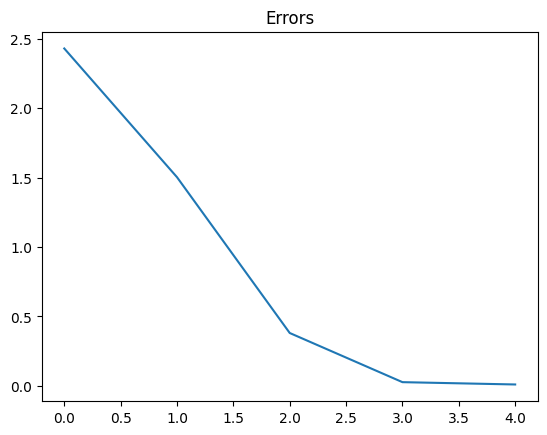

100%|██████████| 1/1 [00:00<00:00, 84.61it/s]

tensor([[7, 8, 3, 8, 5, 7, 4, 9, 3, 3],
        [3, 4, 6, 5, 8, 7, 5, 4, 9, 7]])
tensor([[7, 8, 3, 8, 5, 7, 4, 9, 3, 3],
        [3, 4, 6, 5, 8, 7, 5, 4, 9, 7]])


In [15]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

param = {"batch_size": 100, 
         "src_pad_idx": 0 , 
         "trg_pad_idx": 0,
         "num_train_data": 10000,
         "seq_len":10,
         "vocab_size": 10, 
         "epochs": 5, 
         "num_eval_data": 2,
         "embed_size":20,
         "num_layers":6,
         "forward_expansion":4,
         "heads":5,
         "dropout":0,
         "device":device,
         "max_length":100,}

sequences_train = torch.randint(3,param["vocab_size"],(param["num_train_data"], param["seq_len"]) )
sequences_eval = torch.randint(3,param["vocab_size"],(param["num_eval_data"], param["seq_len"]) )


class SequenceDataset(Dataset):
    # Take a tensor of tokens of size (num_seq, seq_len).
    # Add a init token to each sequences.
    # When we call __getitem__, return the sequences and the sequences flipped.
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.cat((torch.ones(1, dtype=torch.long),self.sequences[idx])), torch.cat((torch.ones(1, dtype=torch.long),torch.flip(self.sequences[idx], dims=(0,))))


training_data = SequenceDataset(sequences_train)
train_dataloader = DataLoader(training_data, batch_size=param["batch_size"])

eval_data = SequenceDataset(sequences_eval)
eval_dataloader = DataLoader(eval_data, batch_size=param["batch_size"])

model = Transformer(
    param["vocab_size"], 
    param["vocab_size"], 
    param["src_pad_idx"], 
    param["trg_pad_idx"], 
    embed_size=param["embed_size"],
    num_layers=param["num_layers"],
    forward_expansion=param["forward_expansion"],
    heads=param["heads"],
    dropout=param["dropout"],
    device=param["device"],
    max_length=param["max_length"]).to(
    device
)
model.train()
loss_cross = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

errors =  []
for epoch in range(param["epochs"]):
  for batch, (X, y) in  enumerate(tqdm(train_dataloader)):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X, y[:,:-1])
    loss = loss_cross(pred.reshape(param["batch_size"]*(param["seq_len"]), param["vocab_size"]), y[:,1:].reshape(param["batch_size"]*(param["seq_len"])))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%100 == 0:
      errors.append(loss.item())
      print(f"\nepochs: {epoch}\nbatch_num:{batch}\nloss:{loss}\n")

plt.plot(errors)
plt.title("Errors")
plt.show()

model.eval()
for batch, (X, y) in  enumerate(tqdm(eval_dataloader)):
    X, y = X.to(device), y.to(device)
    pred = torch.argmax(model(X, y[:,:-1]),dim=2)
    print(y[:,1:])
    print(pred)

In [16]:
for batch, (X, y) in  enumerate(tqdm(eval_dataloader)):
    X, y = X.to(device), y.to(device)
    pred = model(X, y[:,:-1])
    print(X)
    print(y[:,1:])
    print(torch.nn.functional.softmax(pred))
    print(torch.argmax(pred,dim=2))

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_44814/3129857807.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(pred))
100%|██████████| 1/1 [00:00<00:00, 30.41it/s]

tensor([[1, 3, 3, 9, 4, 7, 5, 8, 3, 8, 7],
        [1, 7, 9, 4, 5, 7, 8, 5, 6, 4, 3]])
tensor([[7, 8, 3, 8, 5, 7, 4, 9, 3, 3],
        [3, 4, 6, 5, 8, 7, 5, 4, 9, 7]])
tensor([[[1.8176e-01, 6.4254e-01, 1.6522e-01, 1.2136e-04, 4.3537e-02,
          7.0606e-01, 2.9606e-01, 9.9992e-01, 8.9183e-01, 2.9181e-01],
         [4.9544e-01, 7.8169e-01, 6.3187e-01, 1.8668e-01, 8.9913e-04,
          7.7026e-01, 3.1489e-01, 9.4411e-01, 9.9943e-01, 2.1859e-01],
         [4.7769e-01, 4.2063e-01, 8.1681e-01, 9.9970e-01, 5.8027e-01,
          5.8415e-01, 7.0141e-04, 4.1148e-01, 2.7014e-01, 7.4416e-01],
         [4.2702e-01, 7.9026e-01, 4.3642e-01, 5.2052e-01, 8.5892e-01,
          1.0208e-03, 5.4335e-01, 3.0328e-01, 9.9957e-01, 5.1277e-01],
         [5.0103e-01, 1.9441e-01, 4.2675e-01, 2.6001e-01, 3.1462e-01,
          9.9683e-01, 2.5809e-01, 8.6456e-01, 5.8741e-04, 6.1985e-01],
         [4.9488e-01, 6.1267e-01, 6.2639e-01, 8.6887e-01, 5.6579e-01,
          1.8601e-01, 4.5139e-01, 4.6417e-01, 7.9582e-01,